# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from train_test.load_train import *
from train_test.load_test import *

In [3]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

In [4]:
from models.models_1d import *
from dataloaders.dataset_1d import Dataset_1D
from dataloaders import dataset_2D
from dataloaders import dataset_sparse
from dataloaders.dataset_2d import *
from subprocess import Popen

In [5]:
import matplotlib.animation as animation

# Load dictionary

In [6]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/VideoCond/SparseData_STMoE_2.json" #config_files_1d/lstm_att_1.json
config = {}
with open(json_file) as f:
    config = json.load(f)
    print(f"Read data.json: {config}")

Read data.json: {'cuda_device': 'cuda:2', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_STMoE', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'Dataset_Sparse', 'piezo_head': True, 'normalization': True, 'date_max_norm': '2017-12-31', 'all_dataset': True, 'max_ds_elems': None, '

In [7]:
saving_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/plots"

# Dataset class

In [123]:
importlib.reload(dataset_sparse)

<module 'dataloaders.dataset_sparse' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_sparse.py'>

In [124]:
config["weather_lags"]= 4

In [125]:
ds_2D = dataset_sparse.Dataset_Sparse(config)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_mean': np.float64(298.19569411165224), 'target_std': np.float64(73.65282819016456), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.602
    tmax         float32 4B 12.35
    tmin         float32 4B 5.037
    tmean        float32 4B 8.694, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spa

# Model 

In [10]:
from models import models_2D

In [11]:
importlib.reload(models_2D)

<module 'models.models_2D' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/models_2D.py'>

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [13]:
model = models_2D.SparseData_Transformer(
                weather_CHW_dim = config["weather_CHW_dim"],
                target_dim = config["target_dim"],
                spatial_embedding_dim = config["spatial_embedding_dim"],
                spatial_heads = config["spatial_heads"],
                fusion_embedding_dim = config["fusion_embedding_dim"],
                st_heads = config["st_heads"],
                st_mha_blocks = config["st_mha_blocks"],
                densification_dropout = config["densification_dropout"],
                layernorm_affine = config["layernorm_affine"],
                spatial_dropout = config["spatial_dropout"],
                activation= config["activation"])

In [14]:
model_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models/model_SparseData_Transformer_20250618_183513.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

SparseData_Transformer(
  (activation_fn): LeakyReLU(negative_slope=0.01)
  (SparseAutoreg_Module): Spatial_Attention_Block(
    (activation): LeakyReLU(negative_slope=0.01)
    (topo_embeddings): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (value_embeddings): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (cb_multihead_att_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm_linear): Sequential(
      (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=32, out_features=16, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=16, out_features=16, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
    )
  )
  (ST_Conditioning_Module): ST_Conditioning_Block(
    (activation): LeakyReLU

In [15]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  1614529


In [16]:
lr0 = 0.1
t = np.arange(10)
lr = lr0 * np.e ** (-t)

In [17]:
lr

array([1.00000000e-01, 3.67879441e-02, 1.35335283e-02, 4.97870684e-03,
       1.83156389e-03, 6.73794700e-04, 2.47875218e-04, 9.11881966e-05,
       3.35462628e-05, 1.23409804e-05])

# Predictions

In [18]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

In [19]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds_2D, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds_2D,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal Mask...


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


In [22]:
coords = z_grid.reshape(lat_points,lon_points,3)
coords.shape

(30, 45, 3)

In [23]:
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)

In [24]:
Y_hat_test_grid = (Y_hat_test_grid * ds_2D.norm_factors["target_std"]) + ds_2D.norm_factors["target_mean"]

In [25]:
dtm_denorm = (ds_2D.dtm_roi * ds_2D.norm_factors["dtm_std"]) + ds_2D.norm_factors["dtm_mean"]

In [26]:
dtm_denorm

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 1146, x: 1684)> Size: 8MB
array([[[3165.9429 , 3190.0159 , 3177.3804 , ...,  202.99005,
          202.69525,  202.38904],
        [3127.6099 , 3133.189  , 3113.8975 , ...,  202.14929,
          202.07874,  202.08032],
        [3061.9373 , 3047.077  , 3050.0615 , ...,  201.79285,
          202.26068,  202.2041 ],
        ...,
        [1782.0723 , 1783.2568 , 1794.7913 , ...,  740.06396,
          723.4038 ,  701.9514 ],
        [1861.1785 , 1851.5795 , 1856.2822 , ...,  752.14246,
          725.16925,  706.9846 ],
        [1906.2725 , 1897.0889 , 1896.7747 , ...,  771.21045,
          754.2417 ,  743.1294 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 13kB 6.627 6.627 6.628 6.629 ... 8.027 8.028 8.029
  * y            (y) float64 9kB 45.27 45.26 45.26 45.26 ... 44.31 44.31 44.31
    spatial_ref  int64 8B 0

In [27]:
def plot_h_wtd_maps(sample_h, sample_wtd, 
                 sample_date, pred_timestep,
                 save_dir = None, 
                 print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

    sample_h[pred_timestep,:,:].plot(ax = ax[0])
    ax[0].set_title("Piezometric head")


    sample_wtd[pred_timestep,:,:].plot(ax = ax[1], vmin = sample_wtd.min().values,
                            vmax = sample_wtd.max().values)
    ax[1].set_title("WTD")

    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    if print_plot is True:
        plt.tight_layout()
        
    else:
        return fig 

In [28]:
Y_hat_xr = xarray.DataArray(data = Y_hat_test_grid,
                                coords = dict(
                                            lat=("lat", ((coords[:,0,0] * ds_2D.norm_factors["lat_std"]) + ds_2D.norm_factors["lat_mean"])),
                                            lon=("lon", ((coords[0,:,1] * ds_2D.norm_factors["lon_std"]) + ds_2D.norm_factors["lon_mean"])),
                                            time=pd.date_range(np.datetime64(date),
                                                            np.datetime64(date) + np.timedelta64(twindow-1, config["frequency"]),
                                                            freq = config["frequency"])),
                                dims = ["time","lat", "lon"]
                                )

In [31]:
from rasterio.enums import Resampling

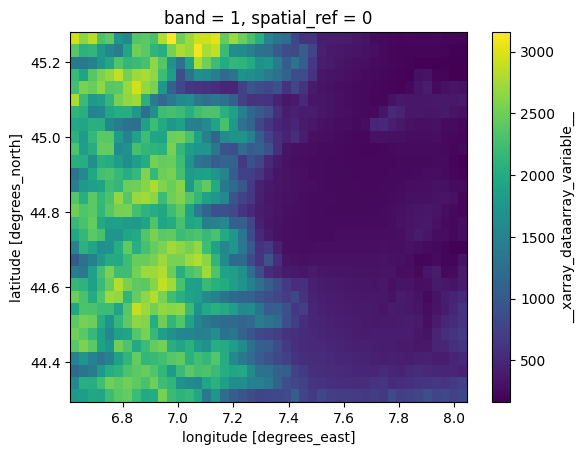

In [29]:
dtm_denorm_xr = dtm_denorm.rio.reproject_match(Y_hat_xr[0].rio.set_spatial_dims(y_dim = "lat", x_dim = "lon").rio.write_crs("epsg:4326"),
                                               resampling = Resampling.average)
dtm_denorm_xr.plot() 

In [30]:
WTD_hat_test_grid = dtm_denorm_xr.values - Y_hat_xr

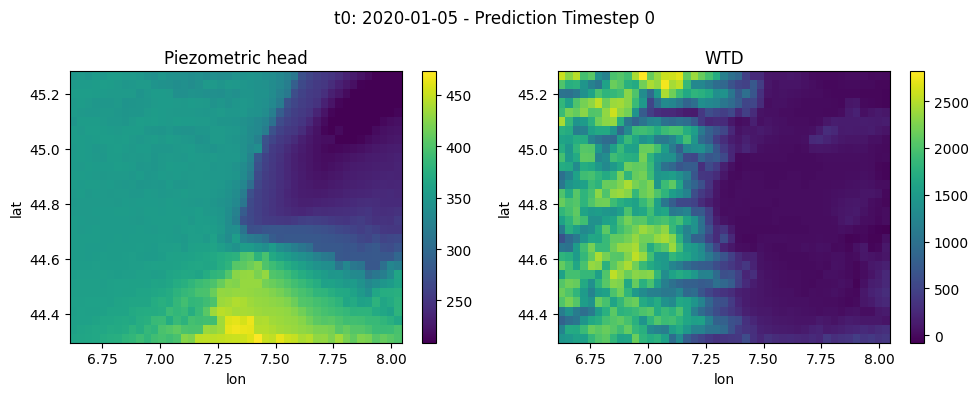

In [31]:
plot_h_wtd_maps(Y_hat_xr, WTD_hat_test_grid, 
                 date, 0,
                 save_dir = None, 
                 print_plot = True)

In [22]:
import matplotlib.animation as animation

In [53]:
np.datetime64("2021-12-19") + np.timedelta64(104, "W")

np.datetime64('2023-12-17')

In [52]:
pd.date_range("2015-12-01", periods = 4, freq = "105W")

DatetimeIndex(['2015-12-06', '2017-12-10', '2019-12-15', '2021-12-19'], dtype='datetime64[ns]', freq='105W-SUN')

In [39]:
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

In [63]:
start_date = '2016-01-03'
n_periods = 16
twindow = 26
start_dates = pd.date_range(start_date, periods = n_periods, freq = f"{twindow}W")

In [64]:
start_dates

DatetimeIndex(['2016-01-03', '2016-07-03', '2017-01-01', '2017-07-02',
               '2017-12-31', '2018-07-01', '2018-12-30', '2019-06-30',
               '2019-12-29', '2020-06-28', '2020-12-27', '2021-06-27',
               '2021-12-26', '2022-06-26', '2022-12-25', '2023-06-25'],
              dtype='datetime64[ns]', freq='26W-SUN')

In [65]:
np.datetime64('2023-06-25')+ np.timedelta64(twindow, "W")

np.datetime64('2023-12-24')

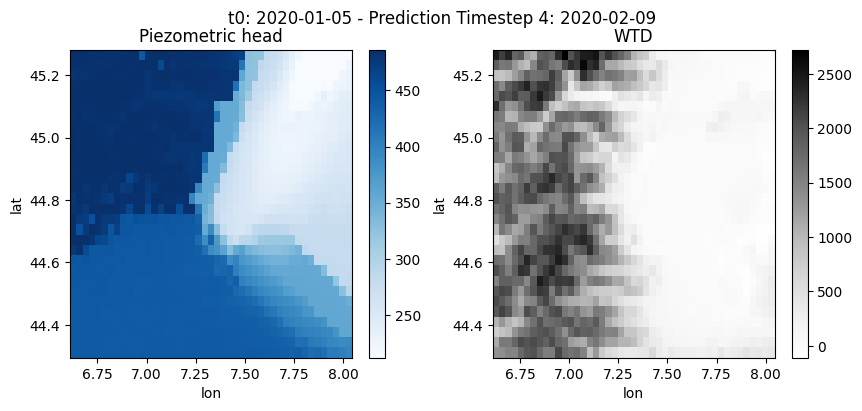

In [40]:
plot.generate_gif_h_wtd(start_date = date, twindow = twindow,
                       sample_h = Y_hat_xr,
                       sample_wtd = WTD_hat_test_grid,
                       freq = "W",
                       save_dir = f'{saving_path}/trial',
                       print_plot = False)

# Plot ST Embdedding

In [27]:
# ST_conditioning_input = W[1][:,:,None,:].expand(-1,-1,Z.shape[1],-1)
#         ST_conditioning_input = torch.cat([ST_conditioning_input,
#                                            Z[:,None,:,:].expand(-1,W[1].shape[1],-1,-1)],
#                                           dim = -1) # B, D, S, C
        
#         ST_Conditionings = self.ST_Conditioning_Module(ST_conditioning_input)

lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds_2D, lat_points,lon_points)
z_grid = torch.from_numpy(z_grid).to(torch.float32)

temp_emb = ds_2D[0][2][1].unsqueeze(0)
sp_emb = z_grid.unsqueeze(0)
ST_cond_input = torch.cat([temp_emb[:,:,None,:].expand(-1,-1,sp_emb.shape[1],-1),
                           sp_emb[:,None,:,:].expand(-1,temp_emb.shape[1],-1,-1)],
                          dim = -1)
ST_conditioning = model.ST_Conditioning_Module(ST_cond_input)

In [28]:
ST_conditioning.shape

torch.Size([1, 24, 1350, 16])

In [29]:
ST_conditioning = ST_conditioning.reshape(1,24,lat_points,lon_points,16)

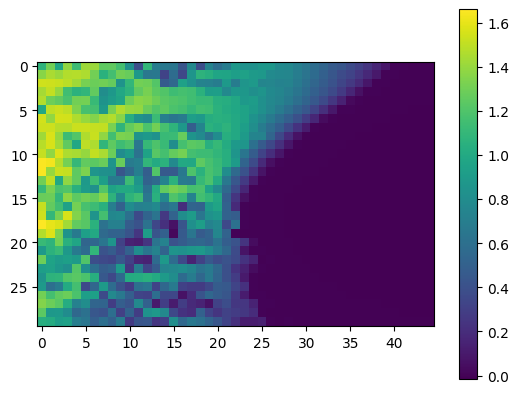

In [44]:
plt.imshow(ST_conditioning[0,1,:,:,2].detach().cpu().numpy())
plt.colorbar()

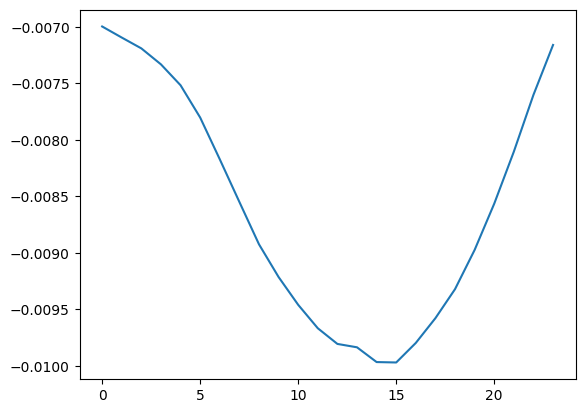

In [48]:
plt.plot(ST_conditioning[0,:,5,0,0].detach().cpu().numpy())

# Old

In [129]:
importlib.reload(dataset_sparse)

<module 'dataloaders.dataset_sparse' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_sparse.py'>

In [131]:
ds_2D = dataset_sparse.Dataset_Sparse(config)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_mean': np.float64(298.19569411165224), 'target_std': np.float64(73.65282819016456), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.602
    tmax         float32 4B 12.35
    tmin         float32 4B 5.037
    tmean        float32 4B 8.694, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spa

In [132]:
ds_2D.input_dates

<DatetimeArray>
['2000-12-31 00:00:00', '2001-01-07 00:00:00', '2001-01-14 00:00:00',
 '2001-01-21 00:00:00', '2001-01-28 00:00:00', '2001-02-04 00:00:00',
 '2001-02-11 00:00:00', '2001-02-18 00:00:00', '2001-02-25 00:00:00',
 '2001-03-04 00:00:00',
 ...
 '2023-05-07 00:00:00', '2023-05-14 00:00:00', '2023-05-21 00:00:00',
 '2023-05-28 00:00:00', '2023-06-04 00:00:00', '2023-06-11 00:00:00',
 '2023-06-18 00:00:00', '2023-06-25 00:00:00', '2023-07-02 00:00:00',
 '2023-07-09 00:00:00']
Length: 1176, dtype: datetime64[ns]

In [133]:
ds_2D[0][2][0].shape

torch.Size([23, 24, 9, 12])

In [140]:
ds_2D[0][2][0][-1,1,:,:]

tensor([[-1.3117, -1.3247, -1.4178, -1.4824, -1.4367, -1.2067, -1.0265, -0.8213,
         -0.7351, -0.7582, -0.7465, -0.7454],
        [-1.1718, -1.2198, -1.2035, -0.7720, -1.2852, -1.2051, -0.9560, -0.7606,
         -0.7479, -0.7250, -0.9504, -0.7351],
        [-1.1534, -1.1220, -1.1923, -1.1497, -1.0238, -1.0653, -0.8168, -0.7912,
         -0.7356, -0.9611, -0.8589, -0.8067],
        [-1.1636, -1.5146, -1.5739, -1.2259, -0.9925, -0.7312, -0.7690, -0.7386,
         -0.7750, -0.8388, -0.8944, -0.8468],
        [-1.4859, -1.5904, -1.5417, -1.4592, -0.6963, -0.7753, -0.7057, -0.7675,
         -0.8031, -0.8688, -0.8865, -0.8519],
        [-1.1280, -1.4788, -1.5714, -1.7744, -1.1580, -0.9662, -0.8947, -0.7594,
         -0.7962, -0.7733, -0.6997, -0.7504],
        [-1.2403, -1.2237, -1.3558, -1.1779, -1.4364, -1.0076, -0.8107, -0.7953,
         -0.7803, -0.7752, -0.8405, -0.8752],
        [-1.3894, -1.4567, -1.2308, -1.2989, -1.1492, -0.9590, -0.8646, -0.8819,
         -0.8261, -0.8564, -0.

In [137]:
ds_2D.weather_xr.sel(time = ds_2D.dates[2]).to_array()

<xarray.DataArray (variable: 4, lat: 9, lon: 12)> Size: 2kB
array([[[-0.51368576, -0.38895145, -0.34051353, -0.45828605,
         -0.61804295, -0.66379535, -0.661149  , -0.67016304,
         -0.67329204, -0.67038417, -0.6677049 , -0.6721761 ],
        [-0.5570158 , -0.4433415 , -0.39770508, -0.4903957 ,
         -0.5978466 , -0.6224357 , -0.63980037, -0.66681063,
         -0.67396456, -0.6642024 , -0.6561565 , -0.65284103],
        [-0.65887445, -0.6455359 , -0.6493368 , -0.6540696 ,
         -0.6175194 , -0.60723704, -0.64609474, -0.667519  ,
         -0.6644605 , -0.6578295 , -0.6481811 , -0.6304464 ],
        [-0.64225966, -0.6525079 , -0.6659181 , -0.6623775 ,
         -0.6463943 , -0.651351  , -0.6719896 , -0.66677535,
         -0.6576465 , -0.65544474, -0.64125   , -0.61476165],
        [-0.6166991 , -0.6129004 , -0.6119658 , -0.6193431 ,
         -0.6370057 , -0.6545141 , -0.6663649 , -0.6692699 ,
         -0.6677794 , -0.6658794 , -0.64929646, -0.62340444],
        [-0.6231469 , -0.6298506 , -0.6329432 , -0.63488066,
         -0.63782316, -0.6469543 , -0.66040367, -0.66659063,
         -0.6689749 , -0.67258763, -0.6491521 , -0.6231452 ],
        [-0.6044793 , -0.6156553 , -0.6425166 , -0.6526153 ,
         -0.63760144, -0.64520216, -0.667038  , -0.6669607 ,
...
         -0.87646157, -1.1756375 , -1.0526325 , -0.9955572 ],
        [-1.6247246 , -1.9310027 , -2.0044048 , -1.7268194 ,
         -1.3659977 , -0.951079  , -0.953052  , -0.89867073,
         -0.9424342 , -1.0243849 , -1.0865571 , -1.0297878 ],
        [-2.0162656 , -2.1454184 , -1.9311247 , -1.8889554 ,
         -1.0150124 , -1.0654671 , -0.931534  , -0.95020384,
         -0.9802361 , -1.0677931 , -1.0831441 , -1.0508907 ],
        [-1.624866  , -2.0170662 , -2.1433878 , -2.4285564 ,
         -1.6633741 , -1.3246157 , -1.093597  , -0.8999396 ,
         -0.9473301 , -0.95888937, -0.9017863 , -0.9812975 ],
        [-1.7968748 , -1.7781259 , -1.9240098 , -1.7317668 ,
         -1.9670585 , -1.2888765 , -0.97296506, -0.92561096,
         -0.92797333, -0.97416764, -1.101399  , -1.165835  ],
        [-1.9751791 , -2.03935   , -1.7574809 , -1.8220519 ,
         -1.6443511 , -1.2257905 , -1.0858787 , -1.0909587 ,
         -1.0376987 , -1.086172  , -0.8953904 , -1.199214  ],
        [-1.7014862 , -1.9233828 , -1.9790115 , -1.6515472 ,
         -1.5874941 , -1.1919109 , -1.2596766 , -1.1335238 ,
         -1.3739363 , -1.6965175 , -1.4073944 , -1.2113575 ]]],
      dtype=float32)
Coordinates:
  * lon          (lon) float64 96B 6.688 6.813 6.938 7.063 ... 7.813 7.938 8.063
  * lat          (lat) float64 72B 45.31 45.19 45.06 44.94 ... 44.56 44.44 44.31
    time         datetime64[ns] 8B 2001-01-14
    spatial_ref  int64 8B 0
  * variable     (variable) object 32B 'prec' 'tmax' 'tmin' 'tmean'
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 14 07:41:14 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

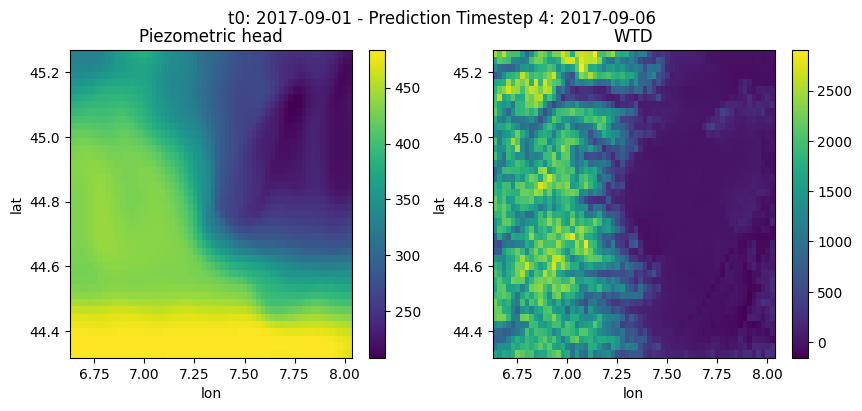

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].set_title("Piezometric head")
ax[1].set_title("WTD")


fig.suptitle(f"t0: {sample_date} - Prediction Timestep {0}")
piezo_image = Y_hat_test_xr_denorm[0,:,:].plot(ax = ax[0], animated=True)
wtd_image = WTD_hat_test_xr_denorm[0,:,:].plot(ax = ax[1], animated=True, 
                                            vmin = WTD_hat_test_xr_denorm.min().values,
                                            vmax = WTD_hat_test_xr_denorm.max().values)


def update_h_wtd_maps(i):
    
    sample_date_i = np.datetime64(sample_date) + np.timedelta64(i+1)
    fig.suptitle(f"t0: {sample_date} - Prediction Timestep {i}: {sample_date_i} ")
    
    ax[0].set_title("Piezometric head")
    ax[1].set_title("WTD")
    
    piezo_image.set_array(Y_hat_test_xr_denorm[i,:,:])
    wtd_image.set_array(WTD_hat_test_xr_denorm[i,:,:])
    
    return (piezo_image, wtd_image)
    
    ## Plot the maps
    
    
ani = animation.FuncAnimation(fig, update_h_wtd_maps, repeat=True, frames=5, interval=1)

writer = animation.PillowWriter(fps=5,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save(f'{saving_path}/trial.gif', writer=writer)

plt.show()

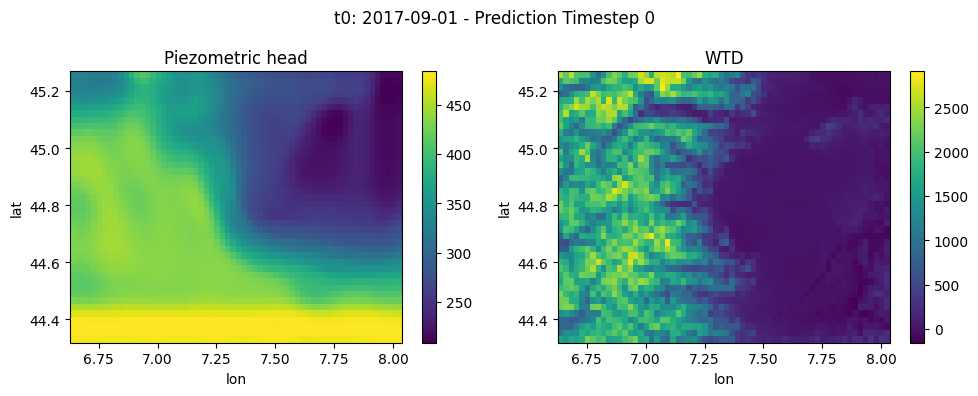

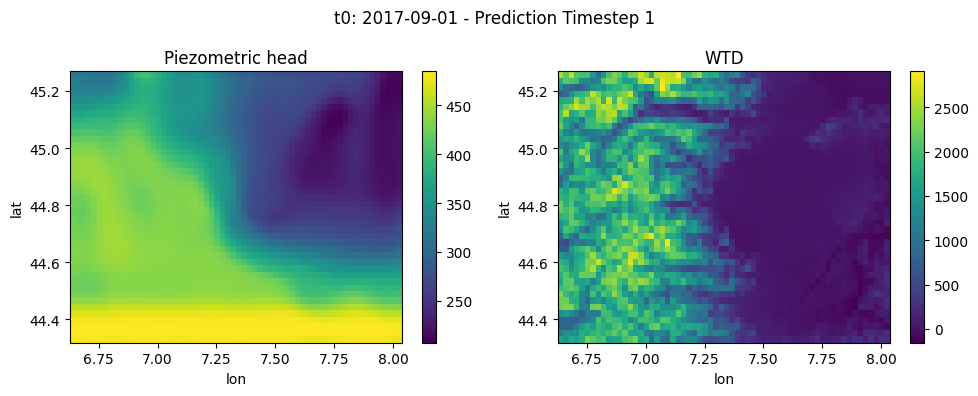

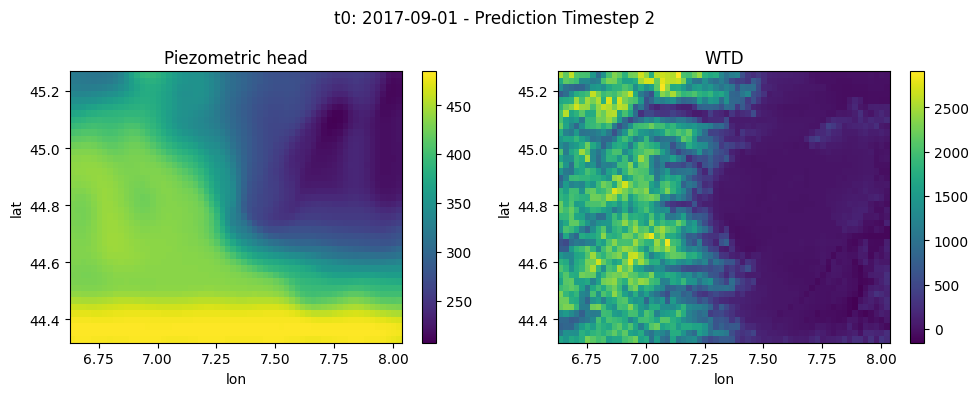

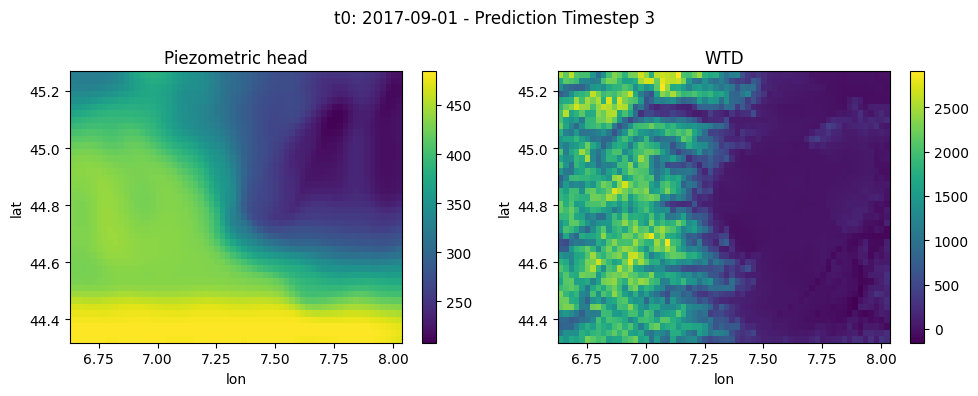

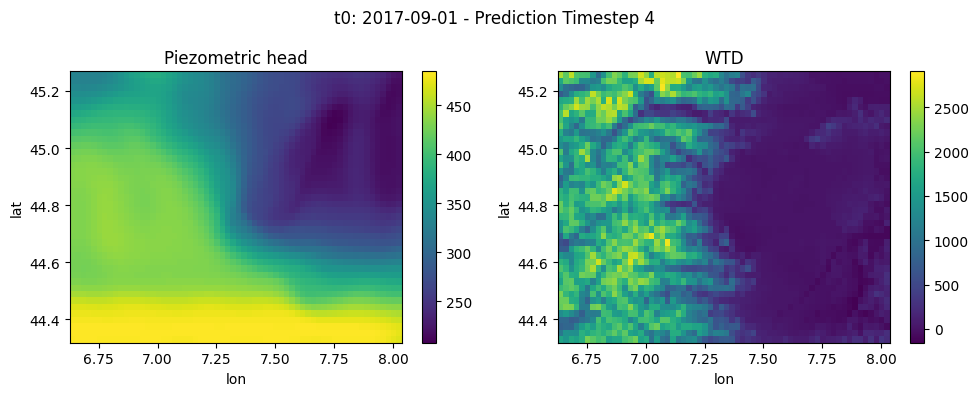

In [18]:
for timestep in range(twindow):
    plot_h_wtd_maps(Y_hat_test_xr_denorm,
                    WTD_hat_test_xr_denorm,
                    sample_date, timestep,
                    save_dir = None, 
                    print_plot = True)

In [53]:
ds_2D.sensor_id_list

array(['00405910001', '00408910001', '00407810001', '00105910001',
       '00112710001', '00126010001', '00417910001', '00422510001',
       '00127210001', '00103510001', '00401210001', '00403410001',
       '00421510001', '00119710001', '00402910001', '00425010001',
       '00105910002', '00414310002', '00109010001', '00127210003',
       '00117110001', '00131010001', '00408910002', '00421710001',
       '00104110001', '00107010001', '00105110001', '00404110001',
       '00121510001', '00104810001', '00127210005'], dtype=object)

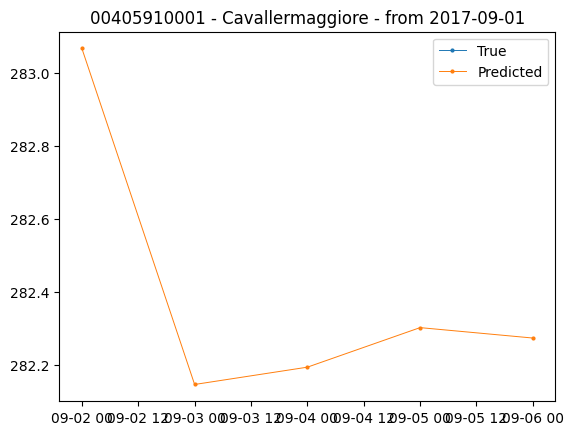

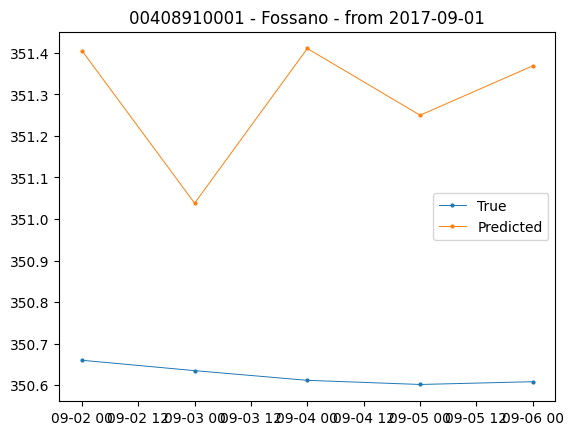

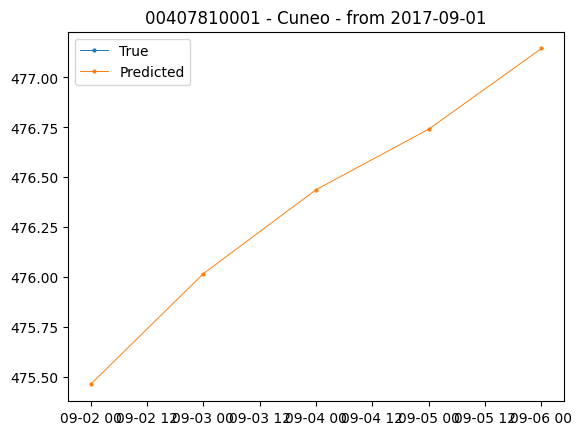

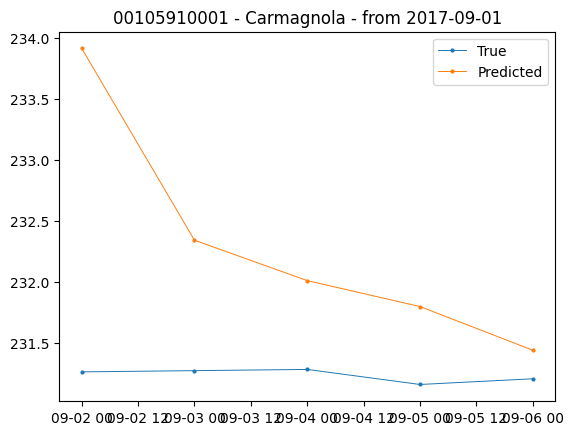

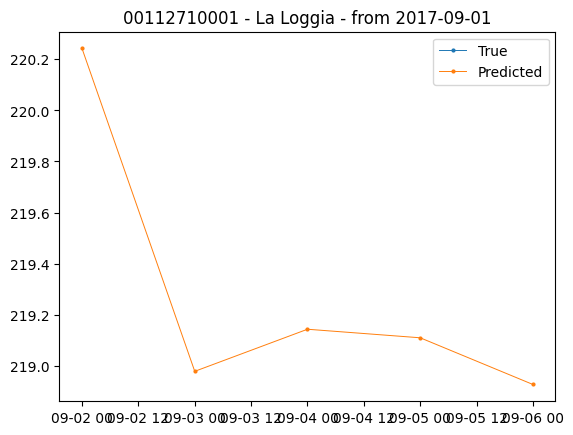

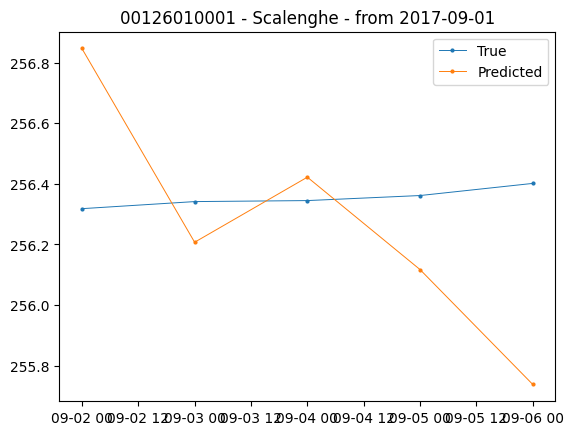

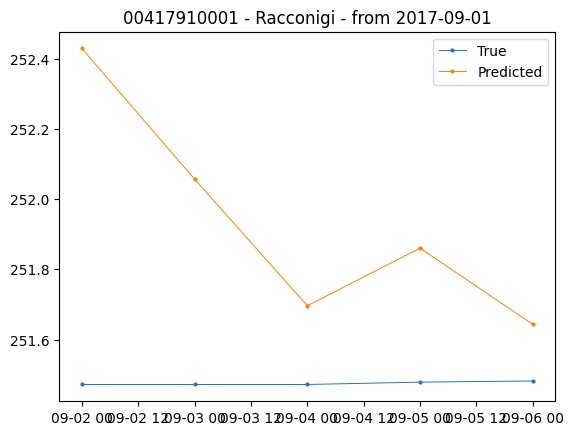

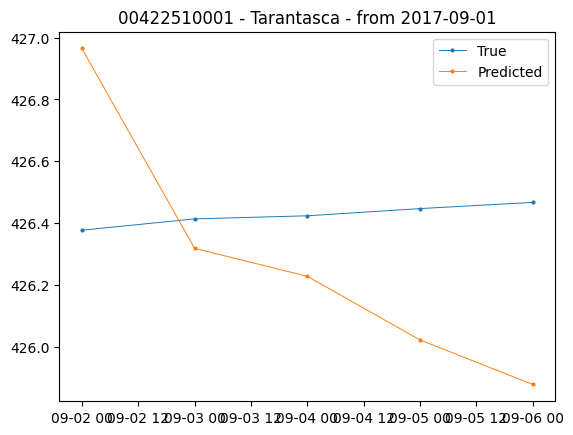

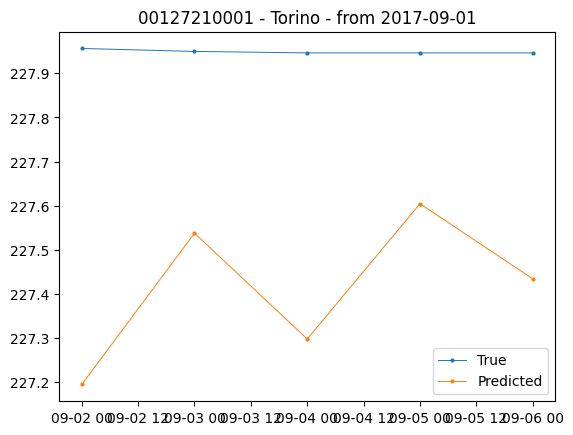

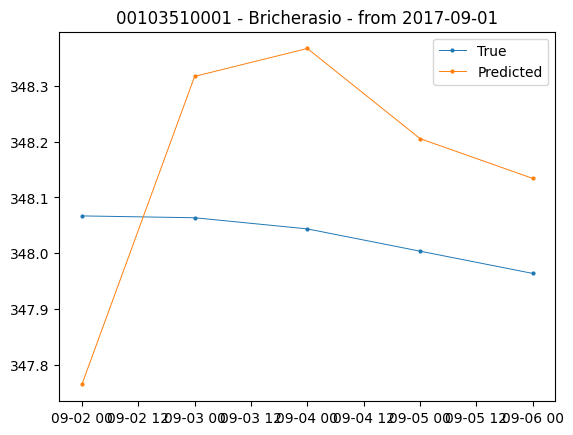

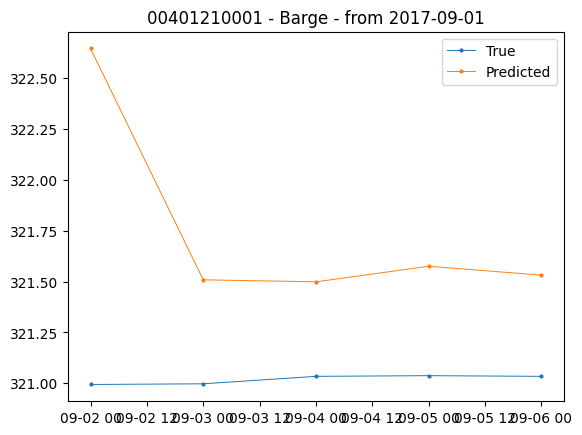

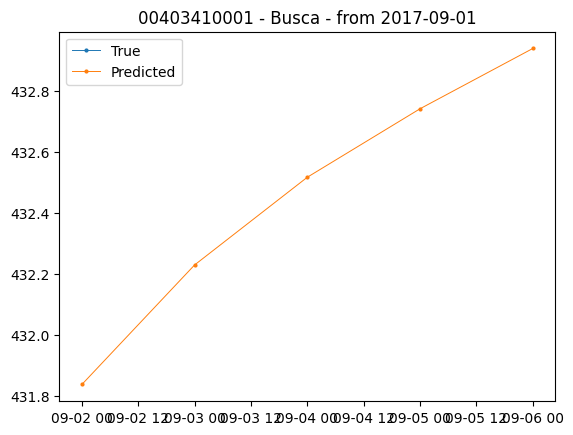

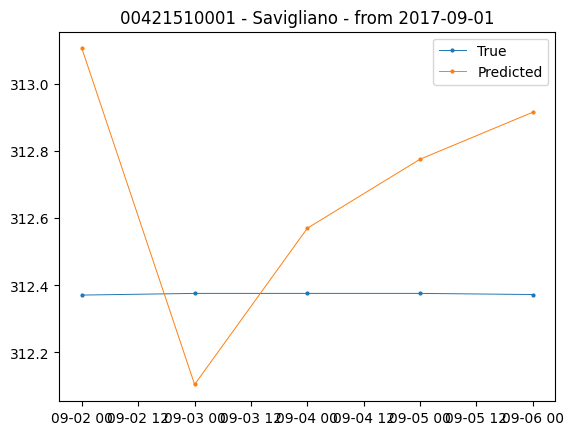

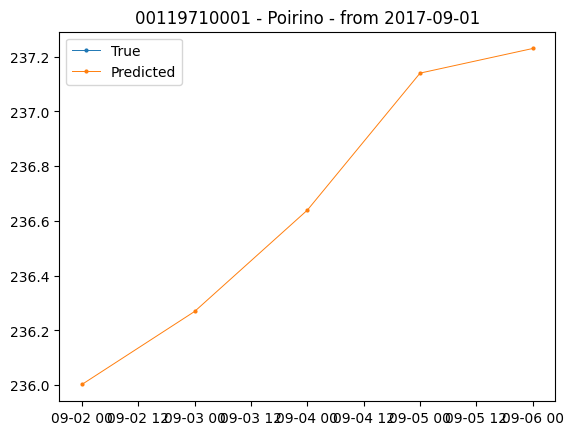

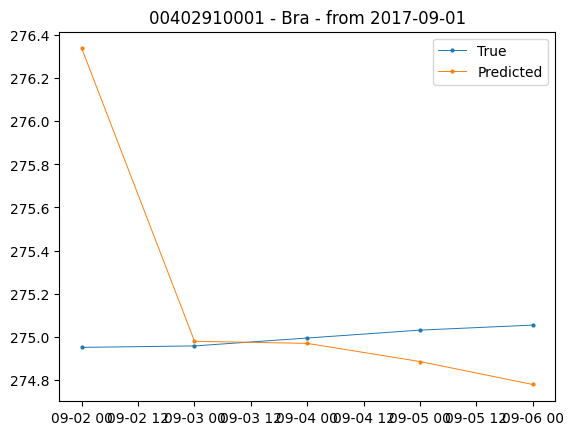

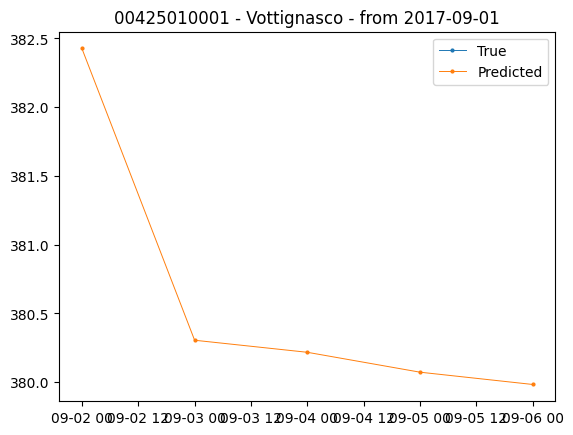

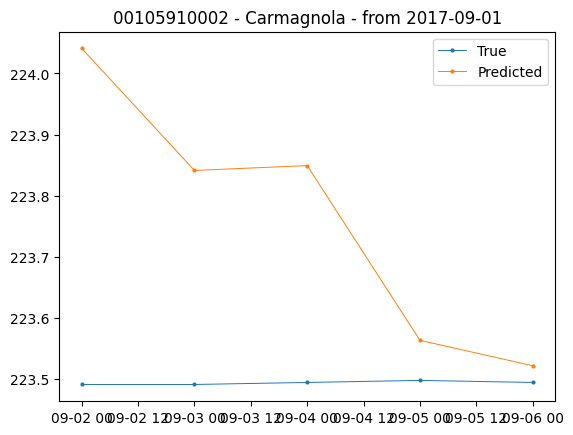

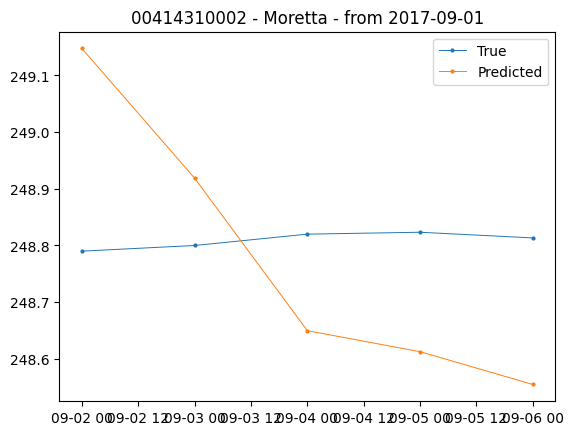

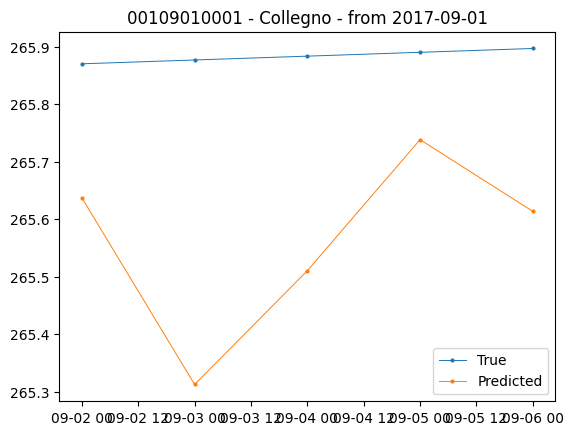

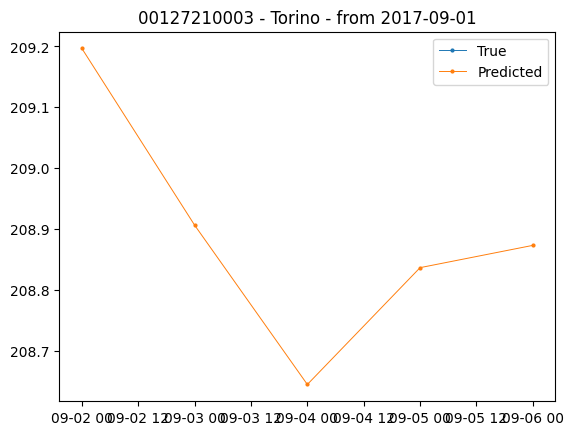

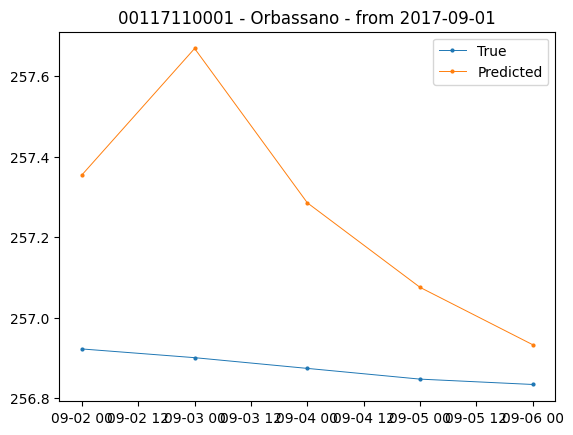

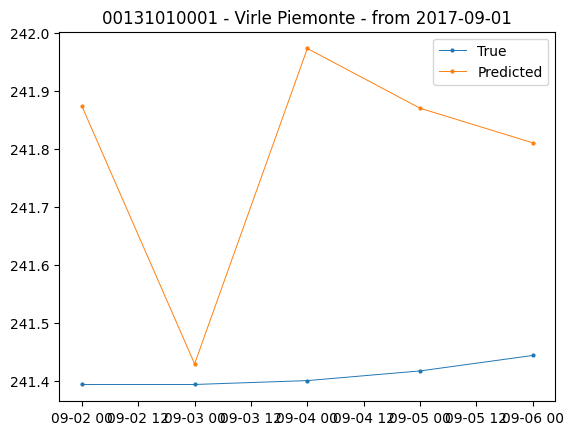

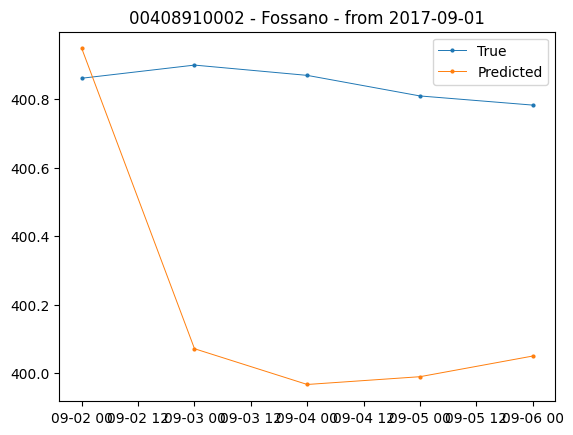

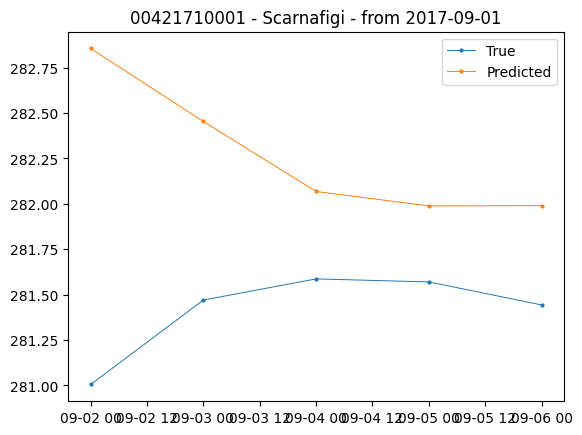

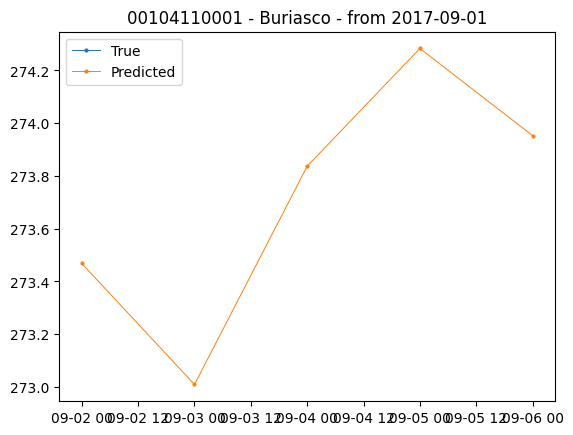

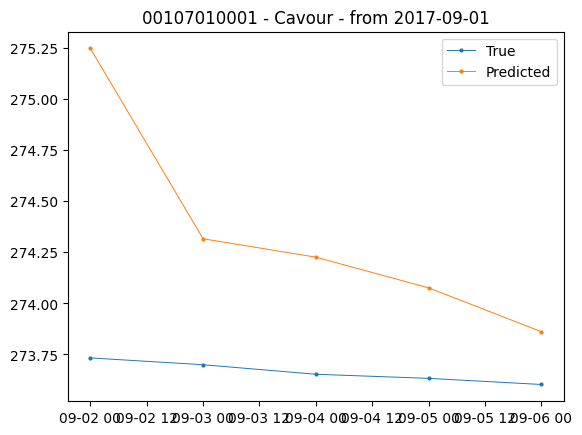

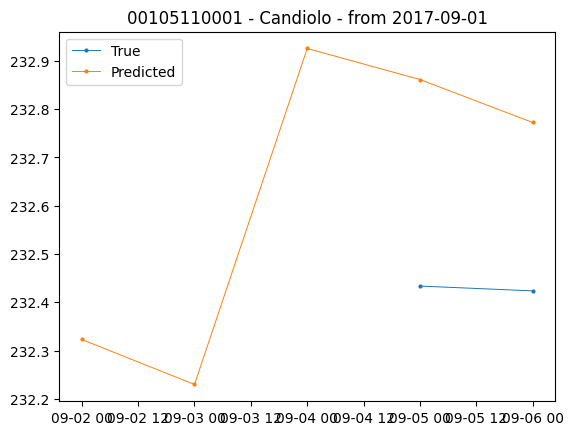

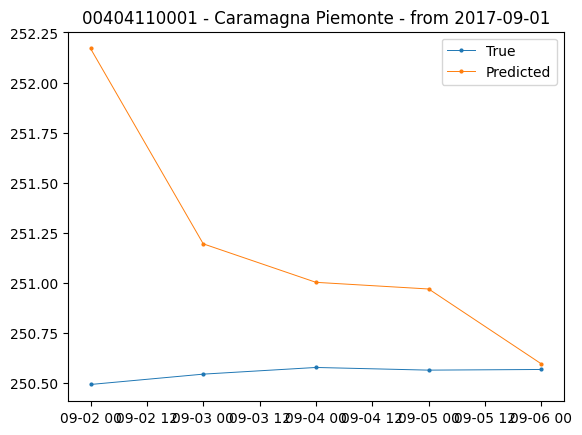

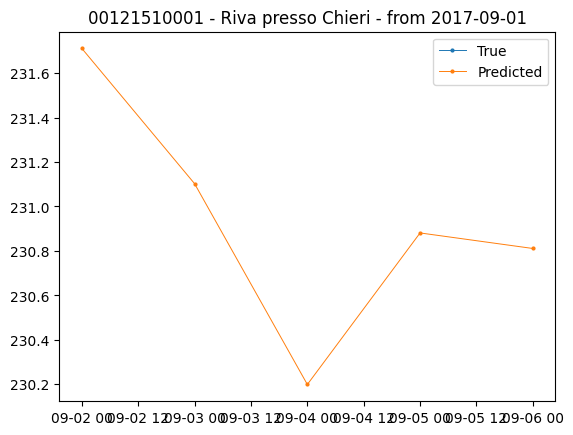

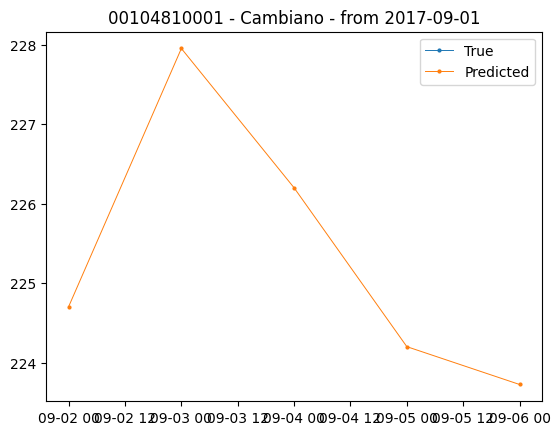

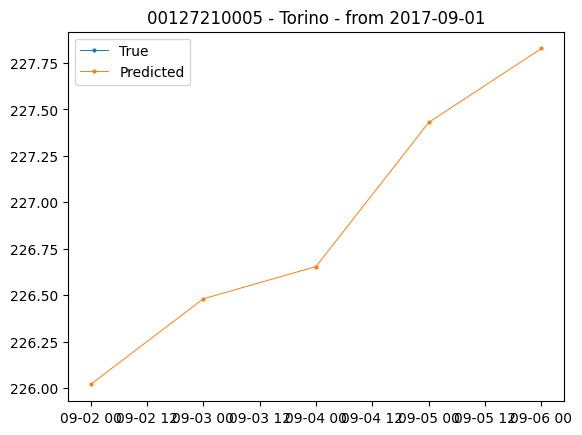

In [19]:
for sensor_id in ds_2D.sensor_id_list:
    municipality, lat, lon = find_munic_lat_lon_sensor(ds_2D, sensor_id)
    sensor_pred_ds = find_sensor_pred_in_xr(Y_test_xr_denorm, Y_hat_test_xr_denorm,
                                                            lat = lat,
                                                            lon = lon,
                                                            )
    
    plot_sensor_ts(sensor_pred_ds,
                    title = f"{sensor_id} - {municipality} - from {sample_date}",
                    save_dir = None,
                    print_plot = True)

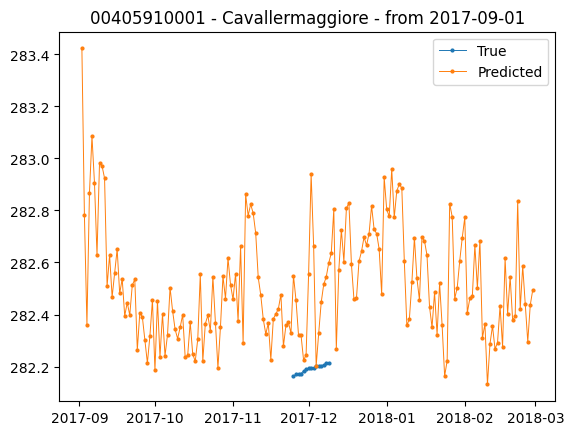

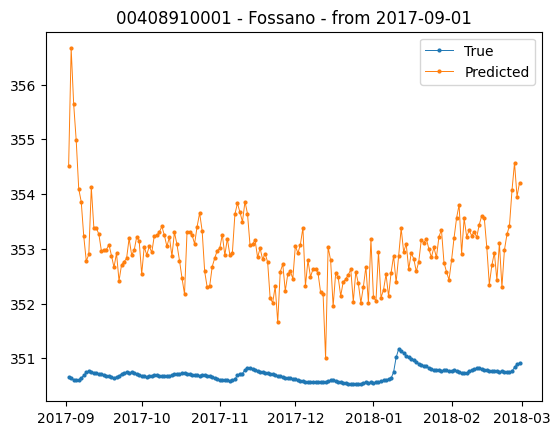

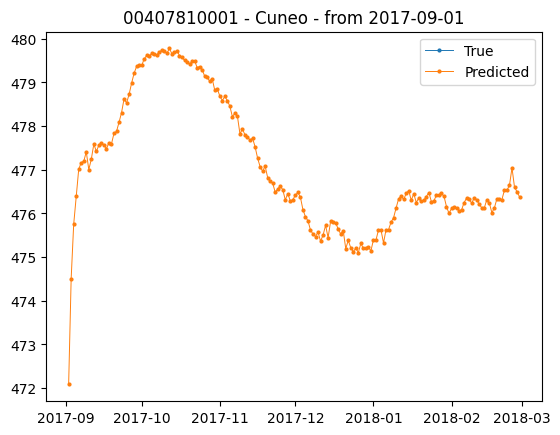

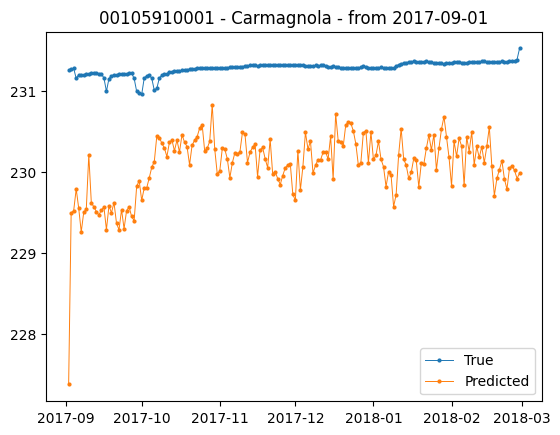

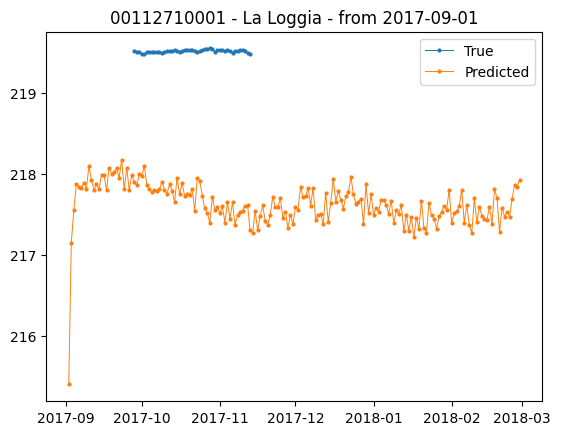

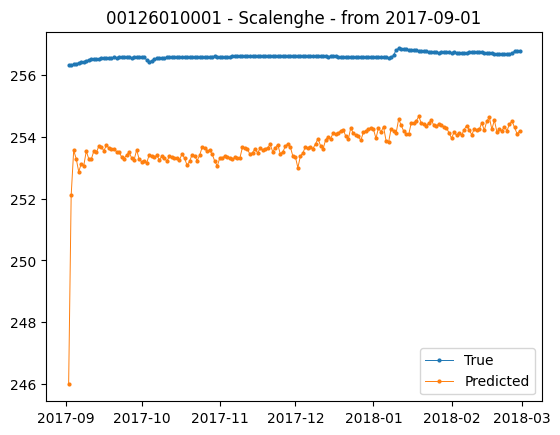

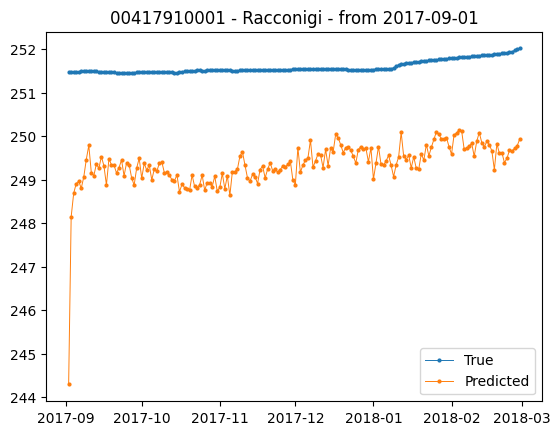

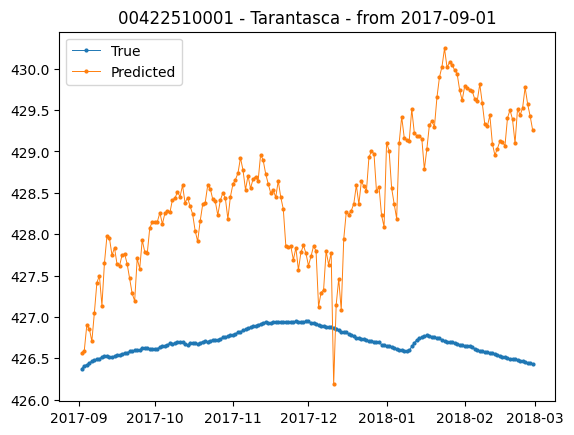

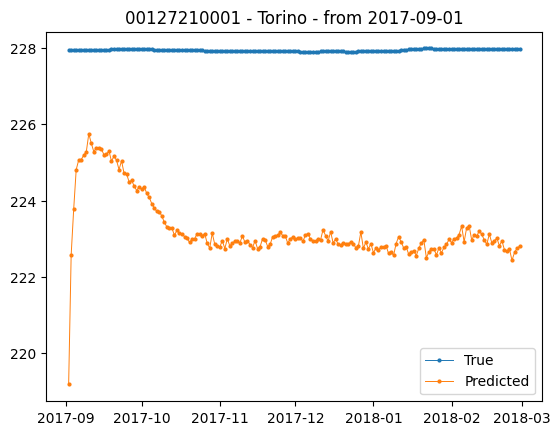

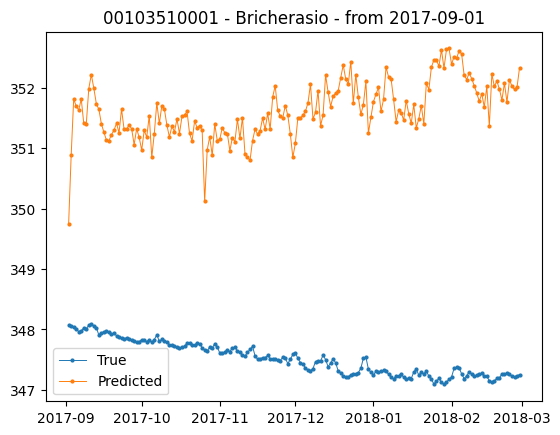

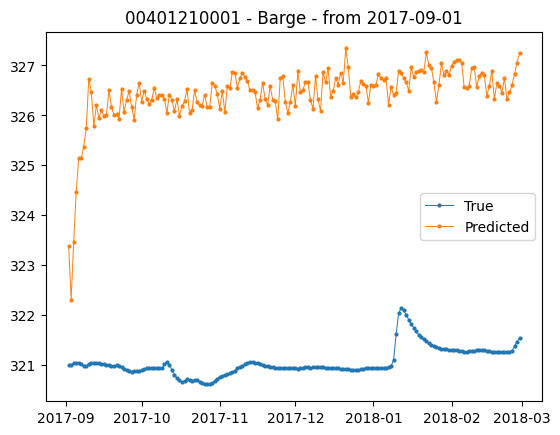

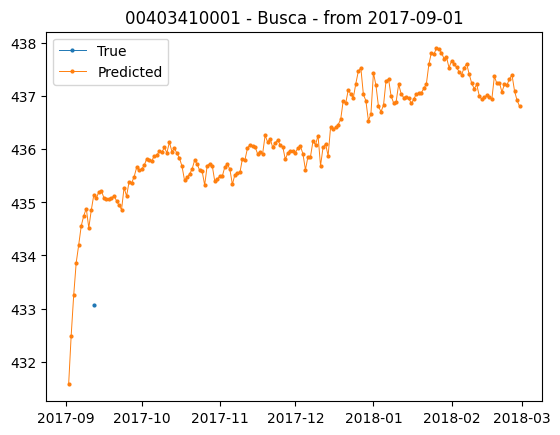

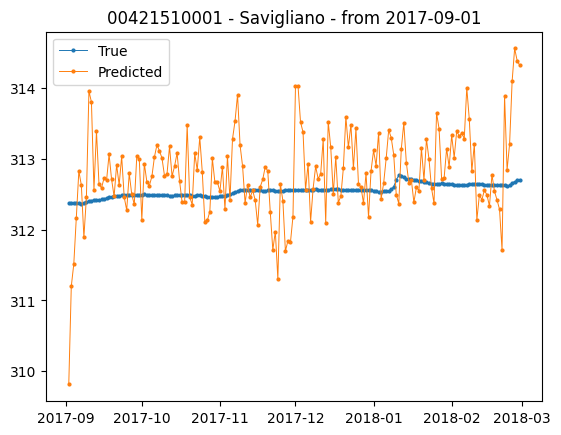

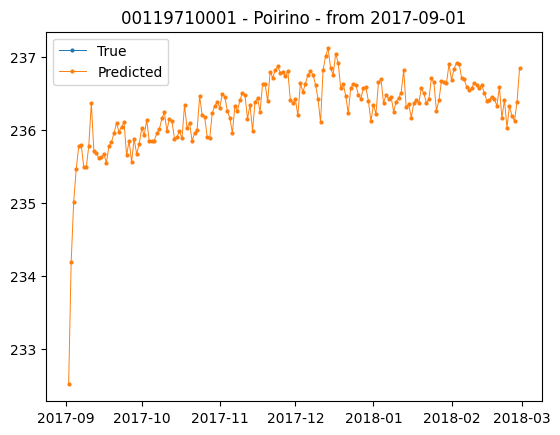

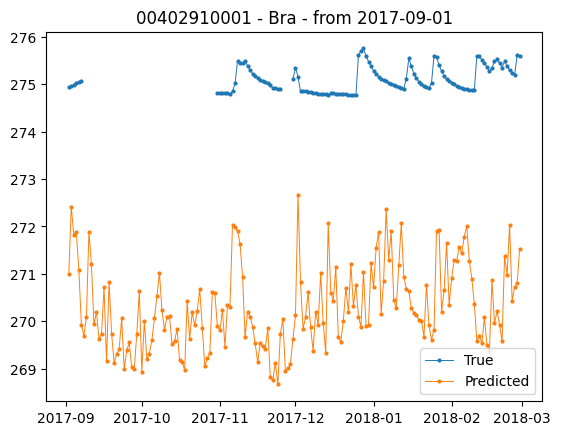

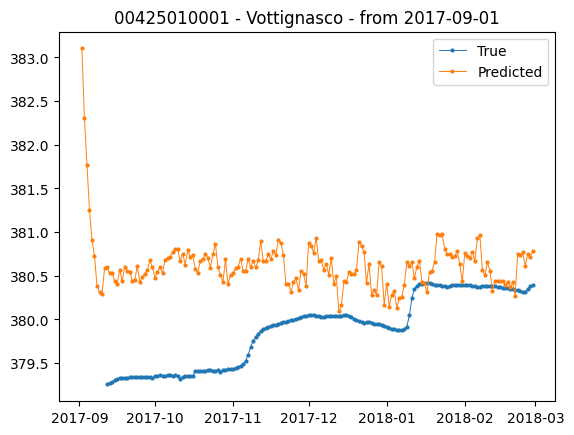

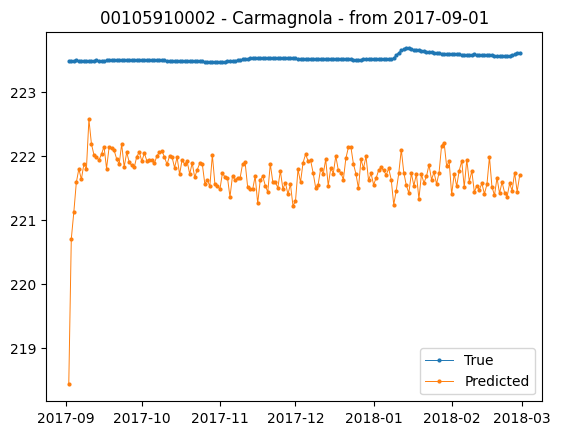

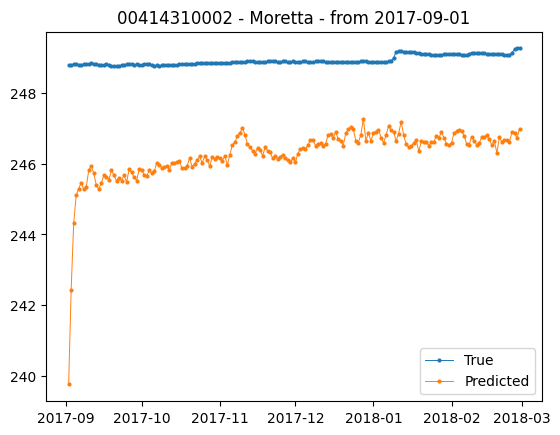

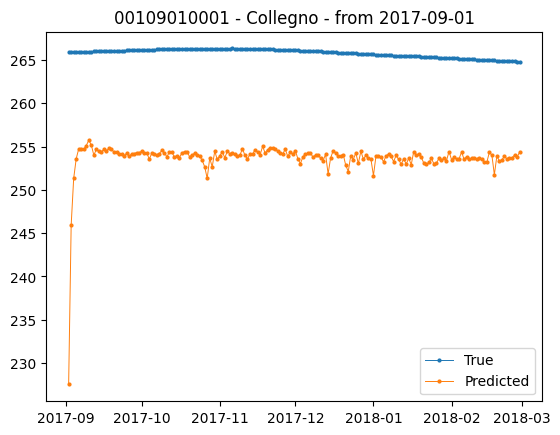

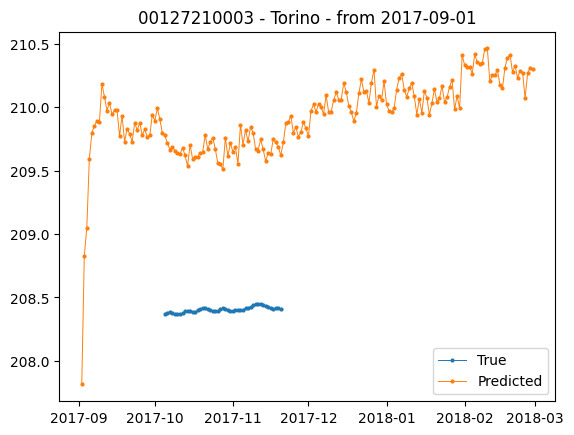

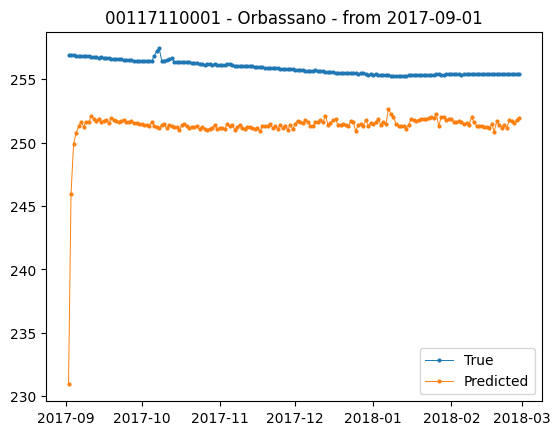

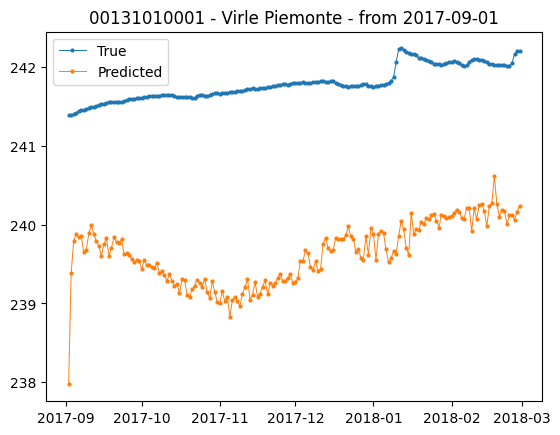

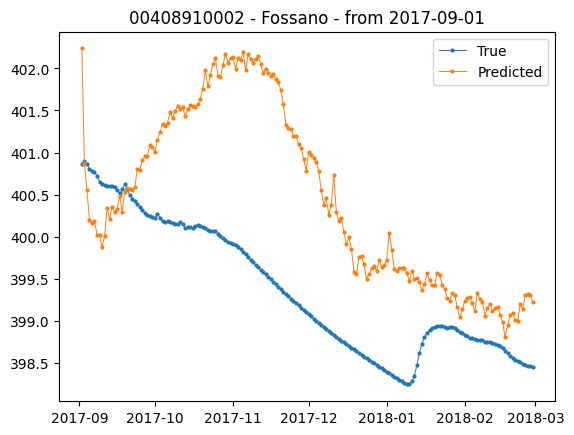

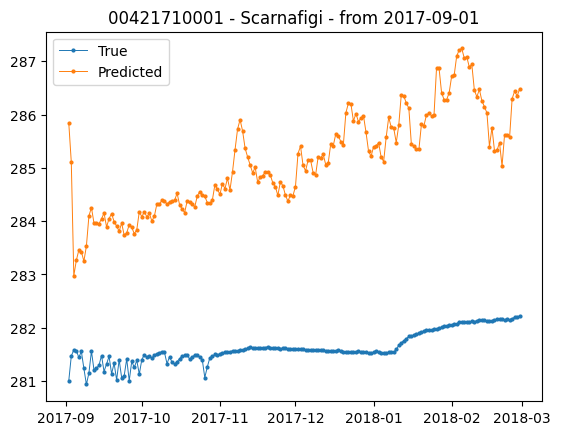

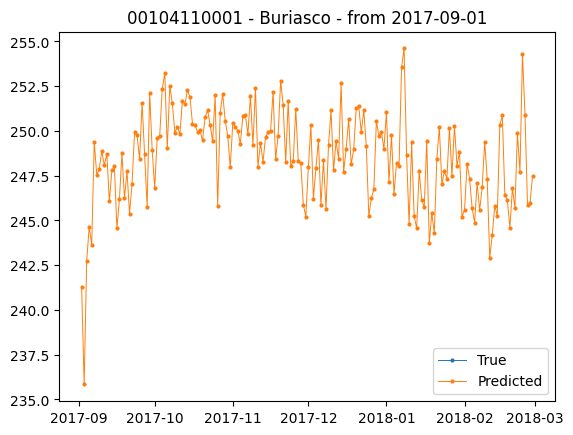

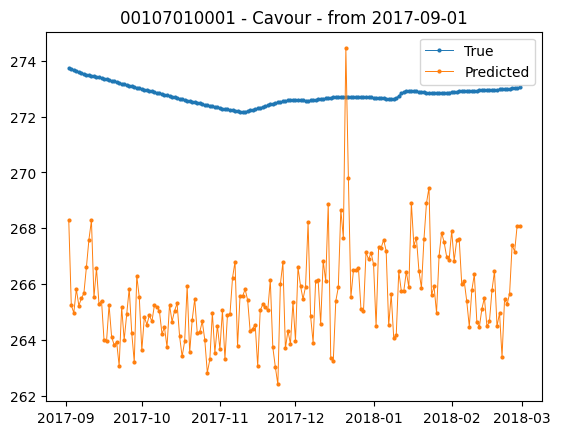

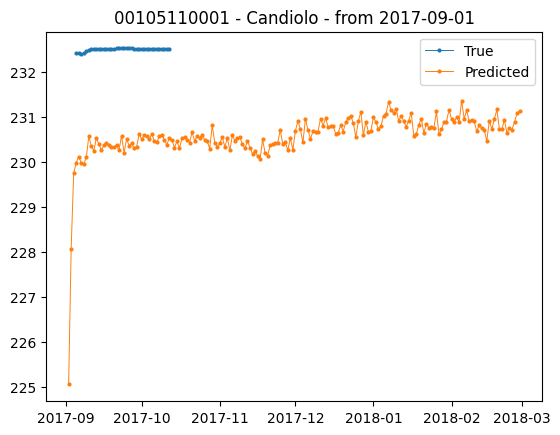

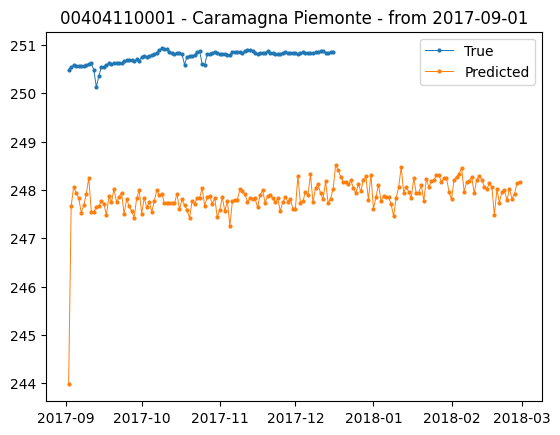

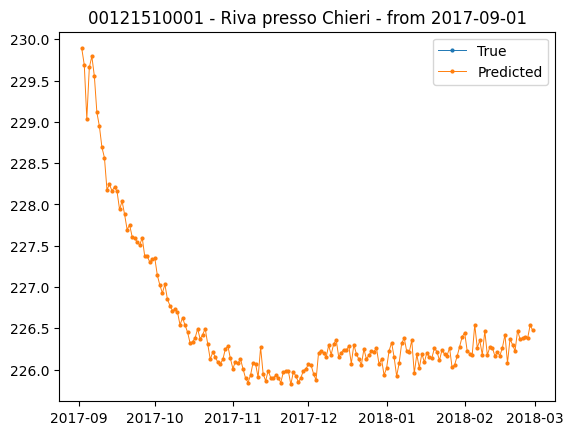

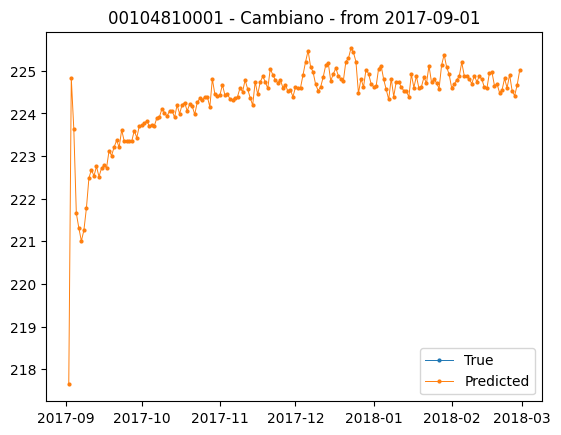

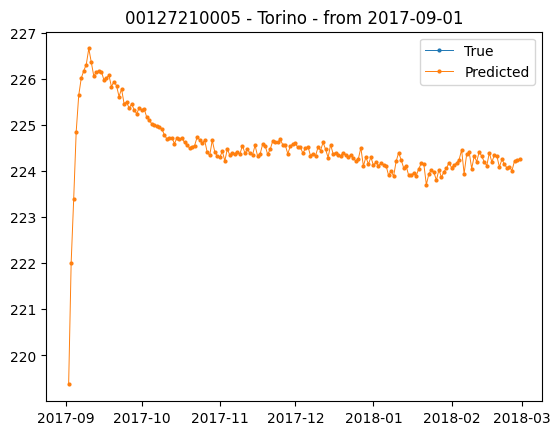

In [54]:
for sensor_id in ds_2D.sensor_id_list:
    municipality, lat, lon = find_munic_lat_lon_sensor(ds_2D, sensor_id)
    sensor_pred_ds = find_sensor_pred_in_xr(Y_test_xr_denorm, Y_hat_test_xr_denorm,
                                                            lat = lat,
                                                            lon = lon,
                                                            )
    
    plot_sensor_ts(sensor_pred_ds,
                    title = f"{sensor_id} - {municipality} - from {sample_date}",
                    save_dir = None,
                    print_plot = True)